In [1]:
import os
os.chdir("..")


In [3]:
%load_ext autoreload
%autoreload 2

from numerics.utilities.misc import *
import numpy as np
from scipy.stats import kstat
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
gammas = np.linspace(110, 10000., 32)

total_time = 8.
dt = 1e-4
times = np.arange(0, 8 + dt, dt )
indis = np.linspace(0,len(times)-1, int(1e4)).astype(int)
timind = [times[k] for k in indis]

def load_gamma(gamma, itraj, what="logliks.npy", flip_params=0):
    h0 = gamma0, omega0, n0, eta0, kappa0 = 100., 0., 1., 1., 9
    h1 = gamma1, omega1, n1, eta1, kappa1 = gamma, 0., 1., 1., 9
    if flip_params != 0:
        params = [h0, h1]
    else:
        params = [h1,h0]
    exp_path = str(params)+"/"
    l =load_data(exp_path=exp_path, itraj=itraj, total_time=8., dt=1e-4, what=what)
    return l

In [6]:
gammas

array([  110.        ,   429.03225806,   748.06451613,  1067.09677419,
        1386.12903226,  1705.16129032,  2024.19354839,  2343.22580645,
        2662.25806452,  2981.29032258,  3300.32258065,  3619.35483871,
        3938.38709677,  4257.41935484,  4576.4516129 ,  4895.48387097,
        5214.51612903,  5533.5483871 ,  5852.58064516,  6171.61290323,
        6490.64516129,  6809.67741935,  7128.70967742,  7447.74193548,
        7766.77419355,  8085.80645161,  8404.83870968,  8723.87096774,
        9042.90322581,  9361.93548387,  9680.96774194, 10000.        ])

In [64]:
stoch = []
det = []
errs = []

B = 8.
dB = .2
boundsB= np.arange(-B,B+dB,dB)

bpos = boundsB[boundsB>=0]
bneg = boundsB[boundsB<0]
epsilon = lambda b: np.exp(-b)/(1 + np.exp(-b))

for gamma in tqdm(gammas):
    try:

        exp_path = "sweep_gamma/{}".format(gamma)
        save_path = get_path_config(exp_path=exp_path,total_time=8., dt=1e-4, noitraj=True)
        stoch.append(np.load(save_path+"times_to_err_stoch.npy"))
        #det.append(np.load(save_path+"times_to_err_det.npy"))
        
        with open(save_path+"deter.pickle","rb") as f:
            deter = pickle.load(f)
            
        alphas = list(deter["h1/h0"].values())
        betas = list(deter["h0/h1"].values())

        alphas = 1.-np.stack(alphas)
        betas = 1.-np.stack(betas)

#        dete = [timind[np.argmin(np.abs((betas[indb,:] + alphas[len(bneg)-indb,:]) - epsilon(b)))] for indb,b in enumerate(bpos)]
        dete = [timind[np.argmin(np.abs((alphas[indb,:] + alphas[len(bneg)-indb,:]) - epsilon(b)))] for indb,b in enumerate(bpos)]

        det.append(dete)

        
        
    except Exception:
        errs.append(gamma)

100%|██████████| 32/32 [00:00<00:00, 48.44it/s]


In [65]:
for k in errs:
    g = list(gammas)
    g.remove(k)
    gammas = g
gammas = np.array(gammas)

In [66]:


stoch = np.stack(stoch)
det = np.stack(det)

ini = 20
fini = 30

100%|██████████| 32/32 [00:01<00:00, 22.98it/s]


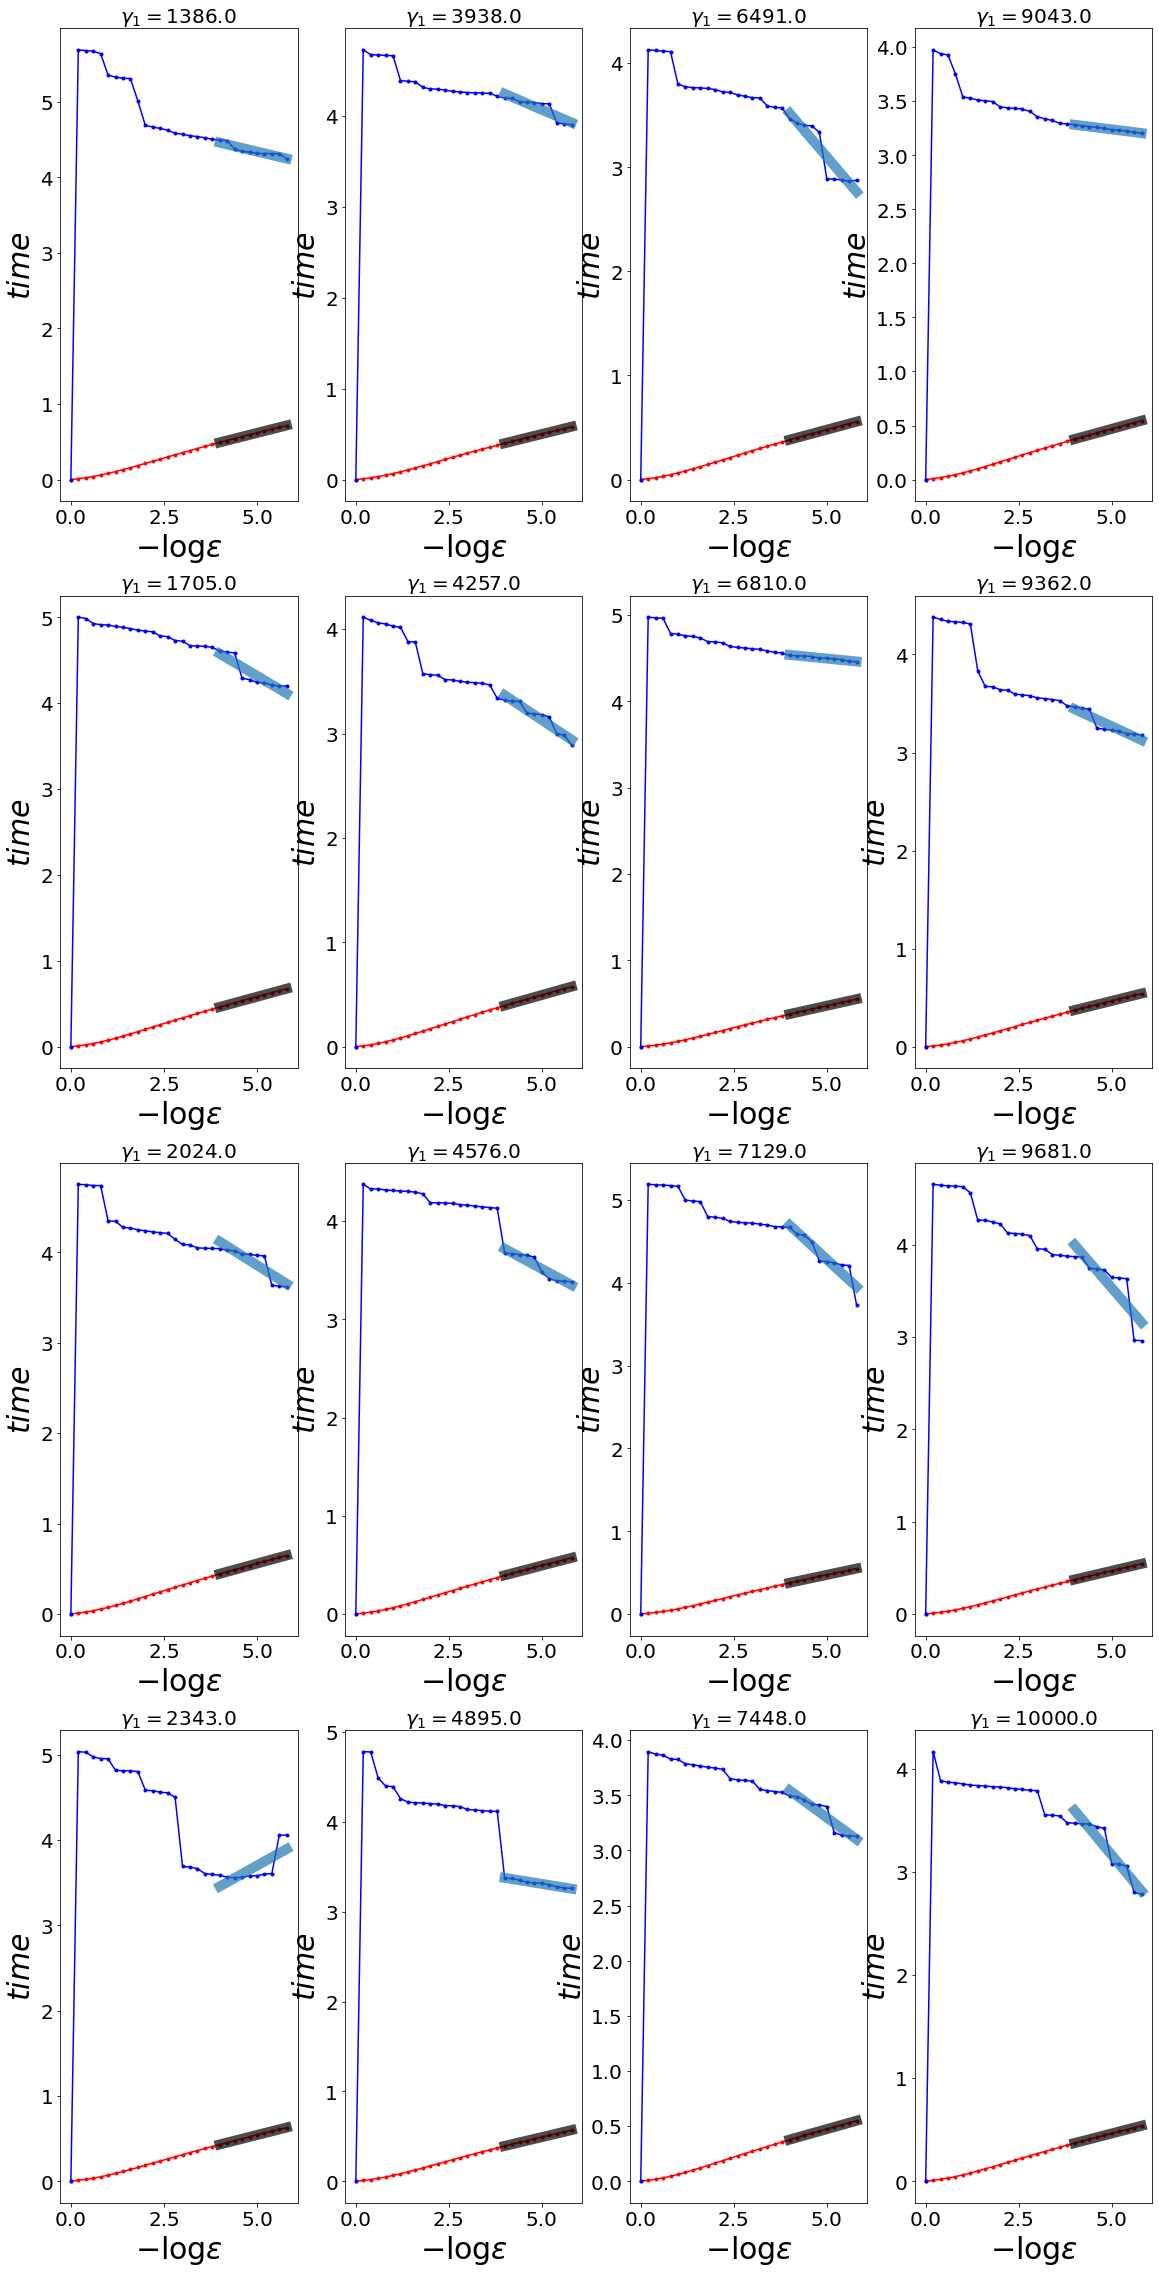

In [67]:
slopes_det, slopes_stoch = [], []
plt.figure(figsize=(40,40))
for i in tqdm(range(stoch.shape[0])):
    if (i == 0):
        continue
    ax = plt.subplot2grid((4,8),(i%4, i//8))
    ax.set_title(r'$\gamma_1 = $'+str(np.round(gammas[i],0)), size=20)
    ax.plot(bpos[:fini],stoch[i,:][:fini],'.-',color="red")
    ax.plot(bpos[:fini],det[i,:][:fini],'.-', color="blue")
    slope_det, oo_det = np.polyfit(bpos[ini:fini], det[i,:][ini:fini], 1)
    ax.plot(bpos[ini:fini], slope_det*bpos[ini:fini] + oo_det,linewidth=10, alpha=0.7)
    slope_stoch, oo_stoch = np.polyfit(bpos[ini:fini], stoch[i,:][ini:fini], 1)
    ax.plot(bpos[ini:fini], slope_stoch*bpos[ini:fini] + oo_stoch,color="black",linewidth=10, alpha=0.7)
    slopes_stoch.append(slope_stoch)
    slopes_det.append(slope_det)
    ax.set_xlabel(r'$-\log \epsilon$',size=30)
    ax.set_ylabel(r'$time$',size=30)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    
#plt.savefig("25K_cropped.pdf")

In [11]:
def give_drift(h0, h1):
    [gamma1, omega1, n1, eta1, kappa1] = h1
    [gamma0, omega0, n0, eta0, kappa0] = h0
    Su1 = n1 + 0.5 + (kappa1 / gamma1)
    Su0 = n0 + 0.5 + (kappa0 / gamma0)

    S1 = (np.sqrt(1 + (16.0*eta1*kappa1*Su1/gamma1)) - 1)*(gamma1/(8.0*eta1*kappa1))
    S0 = (np.sqrt(1 + (16.0*eta0*kappa0*Su0/gamma0)) - 1)*( gamma0/(8.0*eta0*kappa0))

    lam = gamma0 + (8*eta0*kappa0*S0)

    aa = (4*eta1*kappa1*(S1**2))/gamma1
    bb =(4*eta0*kappa0*S0**2)*(1+((16.0*eta1*kappa1*S1)/ (gamma1 + lam)) + (64.0*(eta1 * kappa1 * S1)**(2)/(gamma1 * (gamma1 + lam))))/ lam
    c =8 *(S0*S1*(eta0*kappa0 *eta1*kappa1)**(0.5)) * (gamma1+ (4.0*eta1*kappa1*S1) ) / ((gamma1 + lam)*gamma1)

    mu = 4*(eta1*kappa1*aa + (eta0*kappa0*bb) - 2*np.sqrt(eta1*kappa1*eta0*kappa0)*c)
    return mu
def drifts(h0,h1):
    return np.array([give_drift(h0,h1), give_drift(h1,h0)]    )

In [12]:
dd = []
for g in gammas:
    
    h0 = g, 0., 1., 1., 9
    h1 = 100, 0., 1., 1., 9
    dd.append(drifts(h0,h1))

In [13]:
dd = np.array(dd)

In [14]:
rel_dif_drifts = (dd[:,0]-dd[:,1])/dd[:,0]

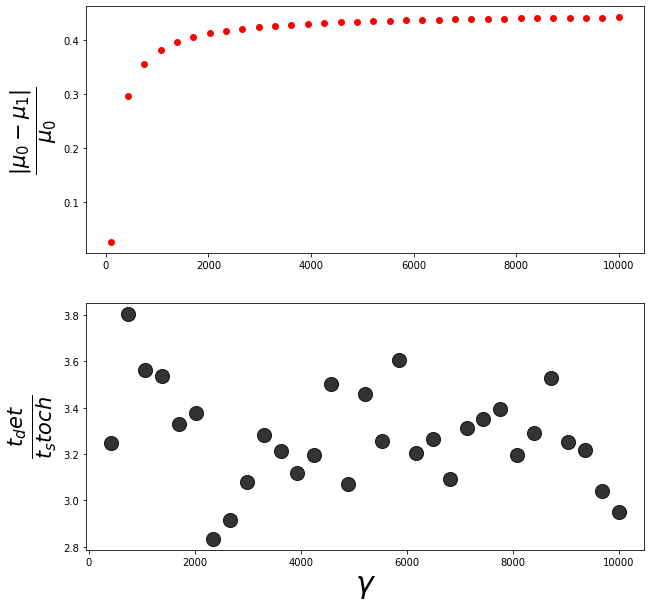

In [16]:
plt.figure(figsize=(10,10))

cmap = plt.get_cmap('gray')
cc = cmap(np.linspace(0,1,len(gammas)))

ax=plt.subplot(211)
ax.scatter(gammas,rel_dif_drifts,linewidth=4, color="red",marker='.')
ax.set_ylabel(r'$\frac{|\mu_0 - \mu_1|}{\mu_0}$',size=30)

ax = plt.subplot(212)
#ax.scatter(gammas,np.array(slopes_det)/np.array(slopes_stoch),  alpha=0.8, s=200)
for k in range(len(gammas)):
    
    ax.scatter([gammas[k]],[(np.array(slopes_det)/np.array(slopes_stoch))[k]], color="black", alpha=0.8, s=200)
ax.set_xlabel(r'$\gamma$',size=30)
ax.set_ylabel(r'$\frac{t_det}{t_stoch}$',size=30)
plt.savefig("record_comparison_tests_slopes_gamma.pdf")

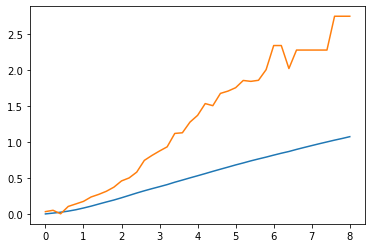

In [11]:
plt.plot(bpos,stoch[10,:])
plt.plot(bpos,det[10,:])

In [9]:
gamma = gammas[-1]

In [10]:
total_time = 8.
dt = 1e-5
times = np.arange(0, 8 + dt, dt )
indis = np.logspace(0,np.log10(len(times)-1), int(1e4)).astype(int)
timind = [times[k] for k in indis]
indis_range = list(range(len(indis)))


Ntraj = int(1e3)
B = 8.
dB = .2
boundsB= np.arange(-B,B+dB,dB)

bpos = boundsB[boundsB>=0]
bneg = boundsB[boundsB<0]


deter, stop = {}, {}
stop["_0"] = {i:[] for i in range(1,Ntraj)}
stop["_1"] = {i:[] for i in range(1,Ntraj)}
deter["h0/h1"] ={indb:[0]*len(indis) for indb in range(len(boundsB))}
deter["h1/h0"] = {indb:[0]*len(indis) for indb in range(len(boundsB))}



def load_gamma(gamma, itraj, what="logliks.npy", flip_params=0):
    h0 = gamma0, omega0, n0, eta0, kappa0 = 100., 0., 1., 1., 9
    h1 = gamma1, omega1, n1, eta1, kappa1 = gamma, 0., 1., 1., 9
    if flip_params != 0:
        params = [h0, h1]
    else:
        params = [h1,h0]
    exp_path = str(params)+"/"
    l =load_data(exp_path=exp_path, itraj=itraj, total_time=8., dt=1e-5, what=what)
    return l

In [11]:
ll = load_gamma(gamma, 1).T

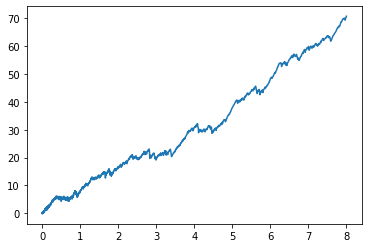

In [12]:
plt.plot(timind,ll[1]-ll[0])

In [13]:
from analysis.misc import *

In [14]:

n=1
ers = []
Ntraj = 1000
for itraj in tqdm(range(1,Ntraj)):
    [l1_1,l0_1], [l0_0,l1_0] = load_gamma(gamma, itraj=itraj,what="logliks.npy", flip_params=0).T, load_gamma(gamma, itraj=itraj,what="logliks.npy", flip_params=1).T
    log_lik_ratio, log_lik_ratio_swap = l1_1-l0_1, l1_0-l0_0

    for indb,b in enumerate(boundsB):
        deter["h0/h1"][indb] += ((log_lik_ratio[indis_range] < b).astype(int)  - deter["h0/h1"][indb])/n
        deter["h1/h0"][indb] += ((log_lik_ratio_swap[indis_range] < b).astype(int)  - deter["h1/h0"][indb])/n
        if b>=0:
            stop["_1"][itraj].append(get_stop_time(log_lik_ratio, b, timind))
            stop["_0"][itraj].append(get_stop_time(log_lik_ratio_swap, b,timind))
    n+=1




100%|██████████| 999/999 [05:08<00:00,  3.23it/s]


In [15]:
###########################
#### type I and II errors

alphas = list(deter["h1/h0"].values())
betas = list(deter["h0/h1"].values())

alphas = np.stack(alphas)
betas = np.stack(betas)




In [27]:
avg_err= lambda b: (1-np.exp(-abs(b)))/(np.exp(abs(b)) - np.exp(-abs(b)))

errs_bound = np.array([avg_err(b) for b in bpos])
tot_err = 0.5*(alphas+alphas)



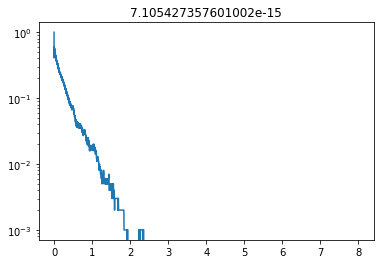

In [22]:
ax=plt.subplot(111)
ax.set_title(boundsB[40])
ax.plot(timind,tot_err[40,:])
ax.set_yscale("log")

In [28]:
symmetric = tot_err[40,:]
times_to_errs = np.array([timind[np.argmin(np.abs(symmetric - bound_err))] for bound_err in errs_bound])

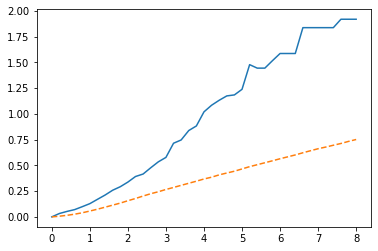

In [31]:
plt.plot(bpos,times_to_errs)
plt.plot(bpos,stoch[-1,:],'--')

In [46]:
indb=0

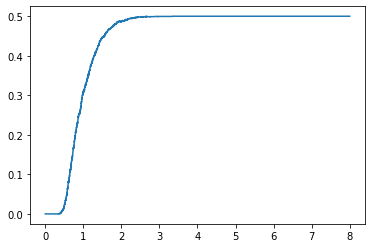

In [48]:
plt.plot(timind,.5*(alphas[indb,:] + betas[indb,:]))

In [24]:
lik_cum = np.load(save_path+"lik_cum.npy").T
mu_cum = np.load(save_path+"st_cum.npy").T

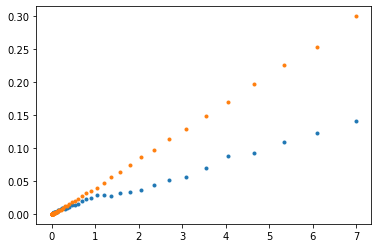

In [222]:
plt.plot(lik_cum[:,0], np.abs(lik_cum[:,1]),'.')
plt.plot(lik_cum[:,0], np.abs(lik_cum[:,2]),'.')

array([1.30656e+00, 3.34251e+00, 4.25754e+00, 4.79856e+00, 6.29774e+00,
       5.00510e+00, 1.00000e-05, 1.00000e-05, 1.00000e-05, 1.00000e-05,
       1.00000e-05, 1.00000e-05, 1.00000e-05, 1.00000e-05, 1.00000e-05,
       1.00000e-05, 1.00000e-05, 1.00000e-05, 1.00000e-05, 1.00000e-05,
       1.00000e-05, 1.00000e-05, 1.00000e-05, 1.00000e-05, 1.00000e-05,
       1.00000e-05, 1.00000e-05, 1.00000e-05, 1.00000e-05, 1.00000e-05,
       1.00000e-05, 1.00000e-05, 1.00000e-05, 1.00000e-05, 1.00000e-05,
       1.00000e-05, 1.00000e-05, 1.00000e-05, 1.00000e-05, 1.00000e-05,
       1.00000e-05])

array([2.00000000e-05, 1.04946167e+00, 3.01129222e+00, 4.17604488e+00,
       5.09610708e+00, 5.29931333e+00,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan])

In [199]:
np.load(save_path+"times_to_err_det.npy")

FileNotFoundError: [Errno 2] No such file or directory: '/data/uab-giq/scratch/matias/quantera/trajectories/mechanical_damp/sweep_gamma/110.0/T_8.0_dt_1e-05/times_to_err_det.npy'

In [56]:
gammas = np.arange(110, 10000, 100).astype("float64")

In [184]:
path = get_path_config(total_time=total_time, dt=dt, itraj=itraj, exp_path=exp_path)
os.makedirs(path, exist_ok=True)

NameError: name 'exp_path' is not defined

In [58]:
gamma = gammas[-1]

In [220]:
M=int(1e3)
ll1 = []
ll0 = []
ers=[]
for itraj in tqdm(range(1,M)):
    try:
        [l1_1,l0_1], [l0_0,l1_0] = load_gamma(gamma, itraj=itraj,what="logliks.npy", flip_params=0).T, load_gamma(gamma, itraj=itraj,what="logliks.npy", flip_params=1).T
        ll1.append(l1_1-l0_1)
        ll0.append(l1_0-l0_0)    
    except Exception:
        ers.append(itraj)
ll1 = np.stack(ll1)
ll0 = np.stack(ll0)

100%|██████████| 999/999 [00:35<00:00, 27.83it/s]


In [214]:
l1 = np.mean(ll1,axis=0)
l0 =np.mean(ll0,axis=0)

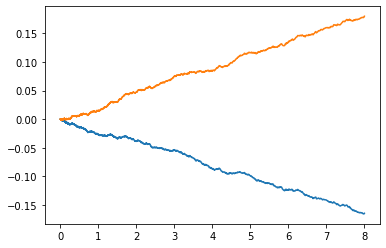

In [215]:
plt.plot(timind, l1)
plt.plot(timind, l0)

In [69]:
cumulants = {}
timind_cum = range(0, ll1.shape[1], 100)
for k in range(1,5):
    cumulants[k] = [kstat(ll1[:,t], k) for t in timind_cum]

In [70]:
cum_vals = np.stack(cumulants.values())

In [79]:
np.array(timind_cum)

array([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
       1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100,
       2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200,
       3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300,
       4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400,
       5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500,
       6600, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600,
       7700, 7800, 7900, 8000, 8100, 8200, 8300, 8400, 8500, 8600, 8700,
       8800, 8900, 9000, 9100, 9200, 9300, 9400, 9500, 9600, 9700, 9800,
       9900])

In [94]:
np.concatenate([np.array(timcum)[np.newaxis],cum_vals]

(5, 100)

(1, 100)

In [72]:
timcum = [timind[k] for k in timind_cum]

In [181]:
def get_diffS(gamma):
    dfs = []
    ers = []
    for itraj in tqdm(range(1,1000)):
        try:

            st11, st01 = load_gamma(gamma, itraj=itraj,what="states1.npy", flip_params=0).T, load_gamma(gamma, itraj=itraj,what="states0.npy", flip_params=0).T
            diff = st11 - st01
            diffSq = np.einsum('tj,tj->j',diff,diff)
            dfs.append(diffSq)
        except Exception:
            ers.append(itraj)
    dfs = np.stack(dfs)

    cums = {}
    timind_cum = range(0, dfs.shape[1], 100)
    for k in range(1,5):
        cums[k] = [kstat(dfs[:,t], k) for t in timind_cum]

    timcum = np.array([timind[k] for k in timind_cum])[np.newaxis]
    cum_vals = np.stack(cums.values())

    return np.concatenate([np.array(timcum),cum_vals])

In [182]:
cumum = get_diffS(110.)

100%|██████████| 999/999 [00:01<00:00, 835.05it/s]
/nfs/pic.es/user/m/mbilkis/qenv_bilkis/lib64/python3.6/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


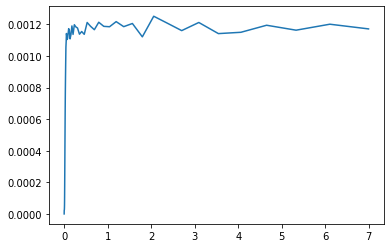

In [183]:
plt.plot(cumum[0],cumum[1] - cumum[2])

In [168]:
np.array(cumum[0][1]) - np.array(cumum[0][2])

array([2.56771005e-07, 2.56771005e-07, 2.56771005e-07, 2.56771005e-07,
       2.56771005e-07, 2.56771005e-07, 5.19993614e-07, 5.19993614e-07,
       5.19993614e-07, 7.99350071e-07, 7.99350071e-07, 1.09541225e-06,
       1.32302406e-06, 1.32302406e-06, 1.60092139e-06, 1.88703776e-06,
       2.14604038e-06, 2.63355612e-06, 2.89059838e-06, 3.49116966e-06,
       3.95562818e-06, 4.43189296e-06, 5.06856271e-06, 5.78820386e-06,
       6.74587705e-06, 7.38378789e-06, 8.65196741e-06, 9.83841546e-06,
       1.05202863e-05, 1.14072650e-05, 1.24901154e-05, 1.35200119e-05,
       1.44951488e-05, 1.58523751e-05, 1.75574025e-05, 1.84389750e-05,
       2.01642041e-05, 2.18783764e-05, 2.28412054e-05, 2.38717530e-05,
       2.50142286e-05, 2.51214542e-05, 2.55674363e-05, 2.57379047e-05,
       2.63788470e-05, 2.78163618e-05, 2.97899269e-05, 3.60897882e-05,
       4.31484440e-05, 5.66406066e-05, 8.15106764e-05, 1.20913016e-04,
       1.75939733e-04, 2.46678317e-04, 3.29140481e-04, 4.29460374e-04,
      

(array([405., 240., 152.,  84.,  55.,  31.,  11.,  14.,   4.,   3.]),
 array([6.46724935e-05, 2.80576952e-01, 5.61089232e-01, 8.41601512e-01,
        1.12211379e+00, 1.40262607e+00, 1.68313835e+00, 1.96365063e+00,
        2.24416291e+00, 2.52467519e+00, 2.80518747e+00]),
 <BarContainer object of 10 artists>)

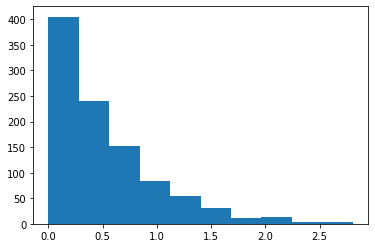

In [157]:
plt.hist(dfs[:,-1])

In [162]:
kstat(dfs[:,timind_cum[-1]], 1)

0.4716605962265899

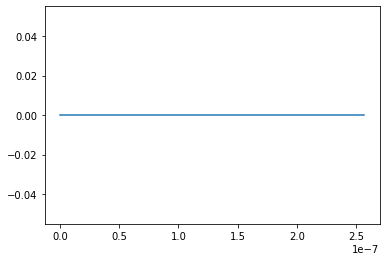

In [156]:
plt.plot(cumum[:,0], cumum[:,1] - cumum[:,2])


In [136]:
cumvals.shape

(5, 100)

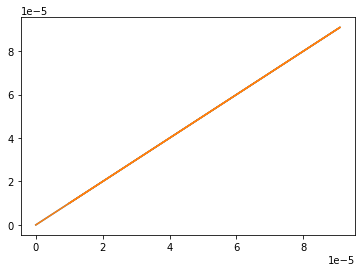

In [123]:
plt.plot(cumvals[:,0], cumvals[:,1])
plt.plot(cumvals[:,0], cumvals[:,4])

In [ ]:
[s11, s01], [s00,s10] = load_gamma(gamma, itraj=itraj,what="states1.npy", flip_params=0).T, load_gamma(gamma, itraj=itraj,what="states.npy", flip_params=1).T


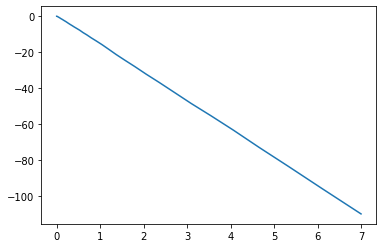

In [62]:
M=int(1e3)
ll1 = []
ll0 = []
ers=[]
for itraj in tqdm(range(1,M)):
    try:
        [l1_1,l0_1], [l0_0,l1_0] = load_gamma(gamma, itraj=itraj,what="logliks.npy", flip_params=0).T, load_gamma(gamma, itraj=itraj,what="logliks.npy", flip_params=1).T
        ll1.append(l1_1-l0_1)
        ll0.append(l1_0-l0_0)    
    except Exception:
        ers.append(itraj)
ll1 = np.stack(ll1)
ll0 = np.stack(ll0)

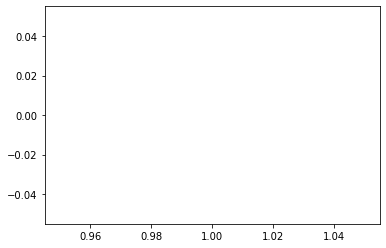

In [82]:
plt.plot([timind[k] for k in timind_cum], cumulants[1])

In [72]:
import matplotlib.pyplot as plt 

In [ ]:
n=1

for itraj in tqdm(range(1,M)):
    log_lik_ratio, log_lik_ratio_swap = load_liks(itraj=itraj, total_time=total_time, dt=dt)
    ll1.append(log_lik_ratio)
    ll0.append(log_lik_ratio_swap)    
ll1 = np.stack(ll1)
ll0 = np.stack(ll0)

In [29]:
load_gamma(210., itraj=900, what="logliks.npy")[

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [33]:
exp_path

'[(110.0, 0.0, 1.0, 1.0, 9), (100.0, 0.0, 1.0, 1.0, 9)]/'

In [35]:
path = get_path_config(total_time=total_time, dt=dt, itraj=1, exp_path=exp_path)
path

'/data/uab-giq/scratch/matias/quantera/trajectories/mechanical_damp/[(110.0, 0.0, 1.0, 1.0, 9), (100.0, 0.0, 1.0, 1.0, 9)]/1itraj/T_8.0_dt_0.01/'

array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [1.75859327e-01, 1.74534677e-01],
       ...,
       [2.25916637e+02, 2.28892487e+02],
       [2.28314854e+02, 2.31372669e+02],
       [2.27835348e+02, 2.30730319e+02]])

In [45]:
data = np.random.randn(2,2000)

In [50]:
data[1]

array([-1.19856734, -1.10453418,  1.71442949, ..., -0.92517384,
       -0.54011586, -0.17580835])

In [51]:
pq.write_table(pa.table({str(k):data[k] for k in range(data.shape[0])}),"here")

In [65]:
pq.read_table("here").to_pandas().T.to_numpy()

array([[-0.16059986,  1.10941365,  0.25992009, ..., -0.02679132,
         1.19097498, -0.49885724],
       [-1.19856734, -1.10453418,  1.71442949, ..., -0.92517384,
        -0.54011586, -0.17580835]])

AttributeError: module 'pyarrow' has no attribute 'parquet'

In [2]:


import numpy as np
import matplotlib.pyplot as plt
from numerics.utilities.misc import *
import matplotlib
from scipy.linalg import solve_continuous_are
import pickle
from tqdm import tqdm
from analysis.misc import *
from scipy.special import erf

params, exp_path = def_params(flip = 0)

which = mode = give_model()
if "mechanical_damp" in which:
    total_time = 4.
    dt = 1e-5
elif which == "mechanical_freq":
    omega = .5*(params[1][1] + params[0][1])
    T_param = 150.
    ppg = 1e3
    period = 2*np.pi/omega
    total_time = T_param*period
    dt = period/ppg
elif (which == "optical_homodyne") or (which == "optical_heterodyne"):
    damping = params[1][0]
    total_time = 200.*damping
    dt = damping/1e3

timind, indis, indis_range = get_timind_indis(total_time, dt, rrange=True)



In [3]:
path_data = get_def_path()+"analysis/{}/".format(20000,mode)

In [4]:
log_lik_ratio, log_lik_ratio_swap = load_liks(itraj=1, total_time=total_time, dt=dt)
B = 8.
dB = .1
boundsB= np.arange(-B,B+dB,dB)
bpos = boundsB[boundsB>=0]

In [5]:
with open(path_data+"deter.pickle","rb") as f:
   deter = pickle.load(f)#, protocol=pickle.HIGHEST_PROTOCOL)

### load (just in case)
timbin1 = np.load(path_data+"timbin.npy")
timbin0 = np.load(path_data+"timbin.npy")#, timbin0)

l0 = np.load(path_data+"l0.npy")
l1 = np.load(path_data+"l1.npy")

cons0 = np.load(path_data+"cons0.npy")
cons1 = np.load(path_data+"cons1.npy")


stoch = np.load(path_data+"times_to_err_stoch.npy")
times_alpha_to_errB = np.load(path_data+"times_to_err_det.npy")

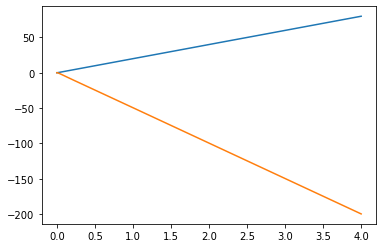

In [6]:
plt.plot(timind, l1)
plt.plot(timind, l0)

In [7]:
FIN = 1000
mu1, _ = np.polyfit(timind[:-FIN], l1[:-FIN],1)
mu0, _ = np.polyfit(timind[:-FIN], l0[:-FIN],1)

In [8]:
alpha_err = np.array([0.5*(1 - erf(0.5*np.sqrt(t*np.abs(mu0)))) for t in timind])
beta_err = np.array([0.5*(1 - erf(0.5*np.sqrt(t*abs(mu1)))) for t in timind])

alphas = np.stack([deter["h1/h0"][k] for k in range(len(boundsB))])
betas = np.stack([deter["h0/h1"][k] for k in range(len(boundsB))])

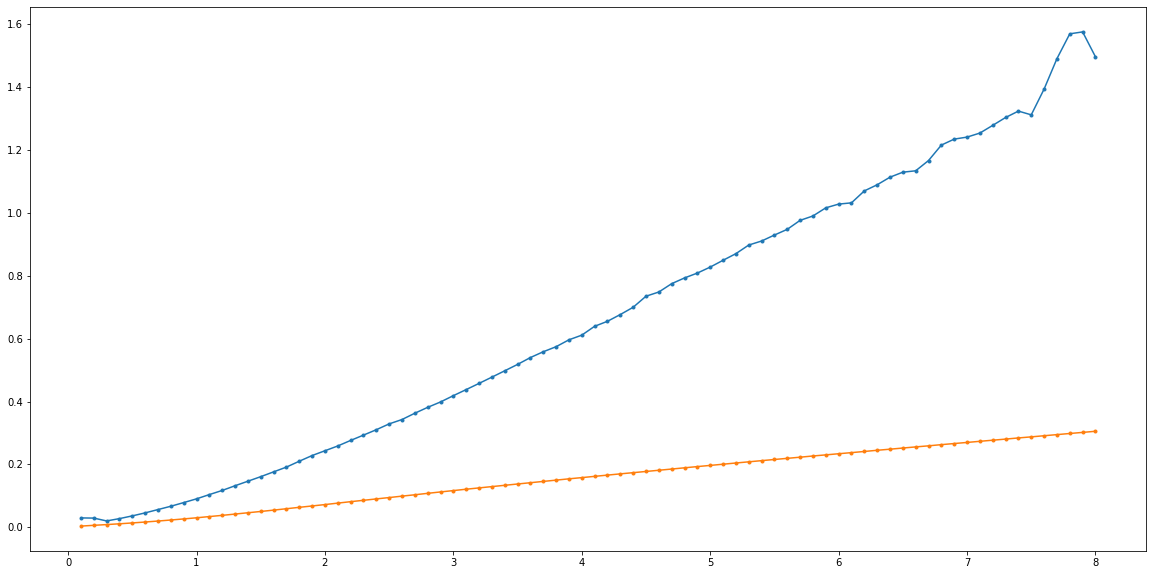

In [9]:
fig = plt.figure(figsize=(20,10))
ax = plt.subplot(111)
ax.plot(bpos, times_alpha_to_errB,'.-')
ax.plot(bpos, stoch,'.-')

In [10]:
inn =20
fin = -20

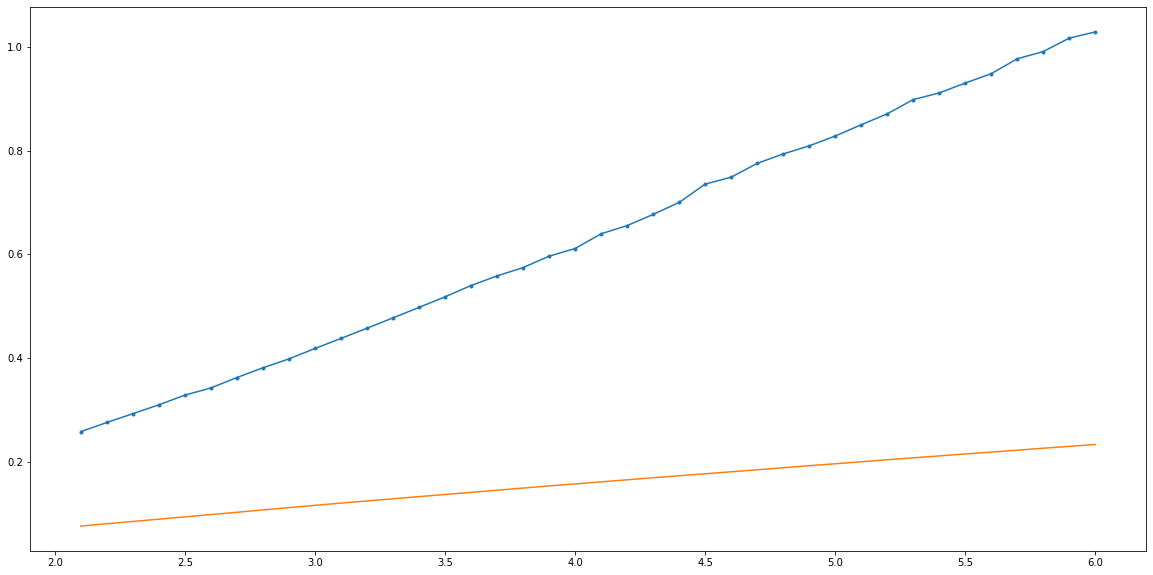

In [11]:
fig = plt.figure(figsize=(20,10))
ax = plt.subplot(111)
ax.plot(bpos[inn:fin], times_alpha_to_errB[inn:fin],'.-')
ax.plot(bpos[inn:fin], stoch[inn:fin])


In [12]:
sDet, odet = np.polyfit(bpos[inn:fin], times_alpha_to_errB[inn:fin],1)
sStoch, oStoch = np.polyfit(bpos[inn:fin], stoch[inn:fin],1)

In [13]:
sDet, sStoch, sDet/sStoch

(0.20191677298311517, 0.040156214547125244, 5.028282054478919)

In [14]:
mu1, mu0

(19.78662093376146, -49.377996312656165)

In [ ]:
n=1
M=int(2e4)
ll1 = []
ll0 = []
for itraj in tqdm(range(1,M)):
    log_lik_ratio, log_lik_ratio_swap = load_liks(itraj=itraj, total_time=total_time, dt=dt)
    ll1.append(log_lik_ratio)
    ll0.append(log_lik_ratio_swap)    
ll1 = np.stack(ll1)
ll0 = np.stack(ll0)

 96%|█████████▋| 19274/19999 [12:48<00:23, 30.80it/s]

In [23]:
os.makedirs("fig_gif", exist_ok=True)

In [38]:
def gaussian(x,mu, sig):
    return np.exp(-(x - mu)**2/(2*sig**2))/np.sqrt(2*np.pi*sig**2)

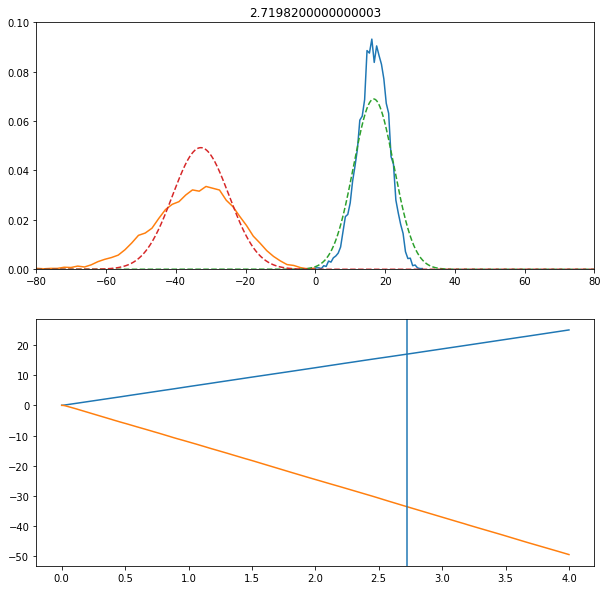

In [49]:
k=-300
c1, b1 = np.histogram(ll1[:,int(k)],bins=50, density=True)
c0, b0 = np.histogram(ll0[:,int(k)],bins=50, density=True)

L=80

plt.figure(figsize=(10,10))
ax=plt.subplot(211)
ax.set_title(timind[int(k)])
ax.plot(b1[:-1], c1)
ax.plot(b0[:-1], c0)
t = timind[int(k)]
eel = np.linspace(-L,L,int(1e4))
dist1 = [gaussian(l, mu1*t, np.sqrt(2*mu1*t)) for l in eel]
dist0 = [gaussian(l, mu0*t, np.sqrt(2*abs(mu0*t))) for l in eel]
ax.plot(eel, dist1,'--')
ax.plot(eel, dist0,'--')
ax.set_xlim([-L,L])
ax.set_ylim([0,.1])    
ax=plt.subplot(212)
ax.plot(timind, l1)
ax.plot(timind, l0)
ax.axvline(timind[int(k)])

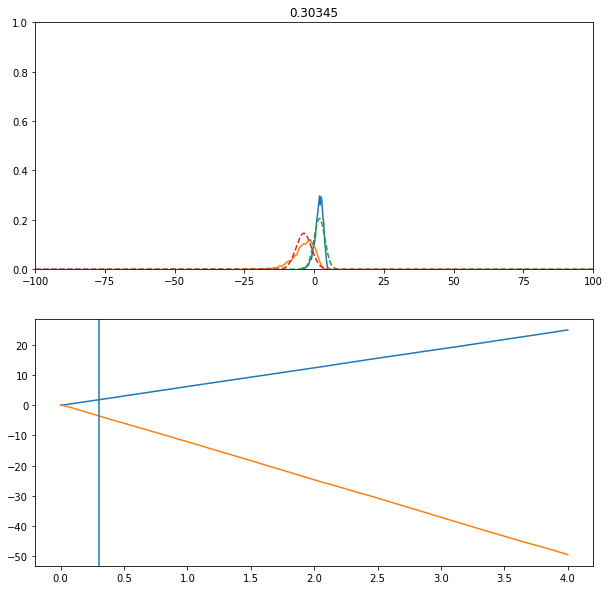

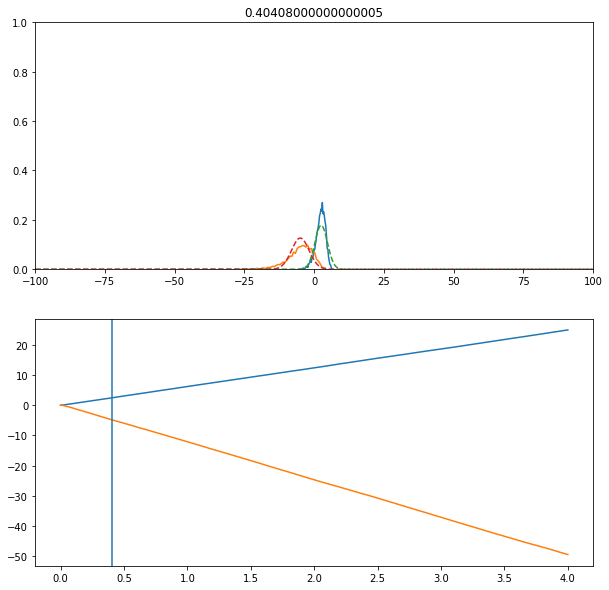

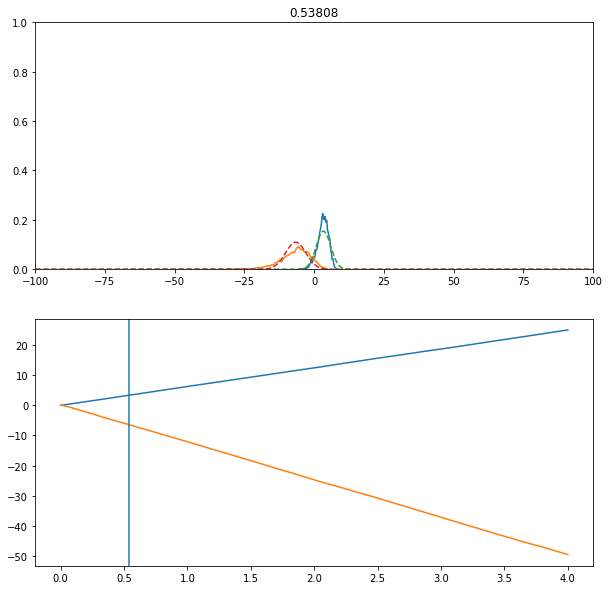

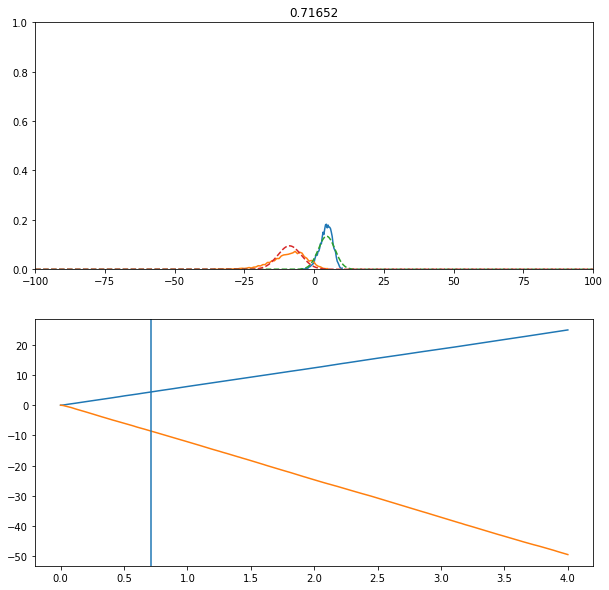

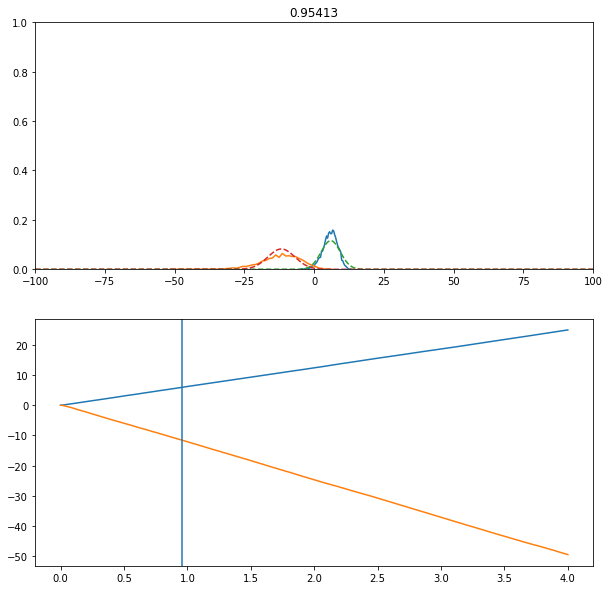

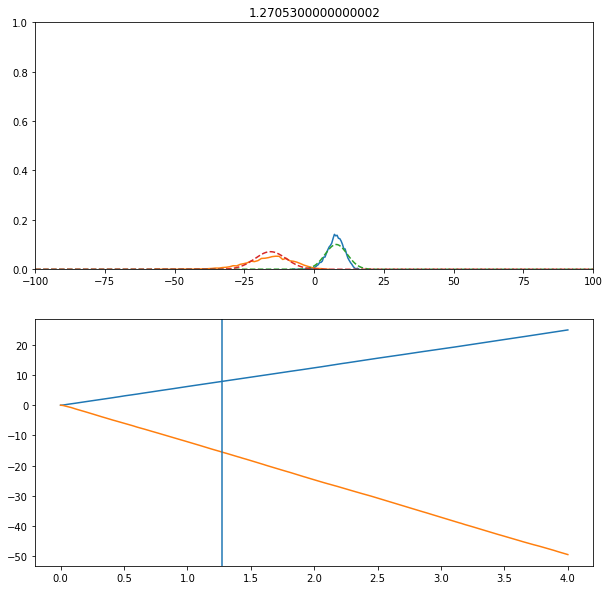

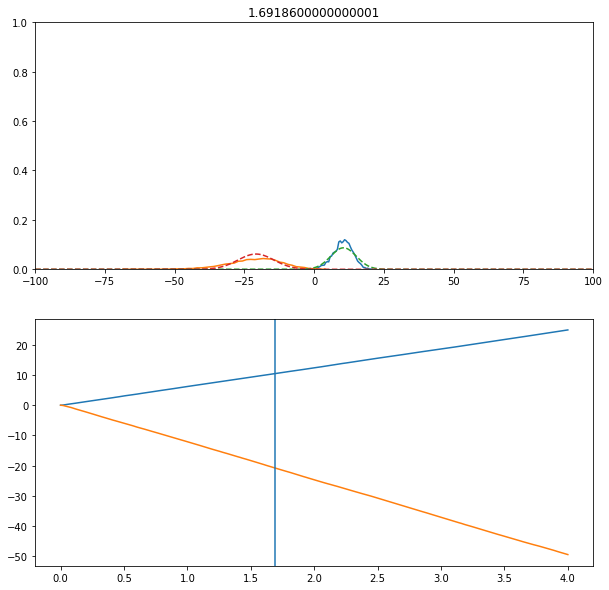

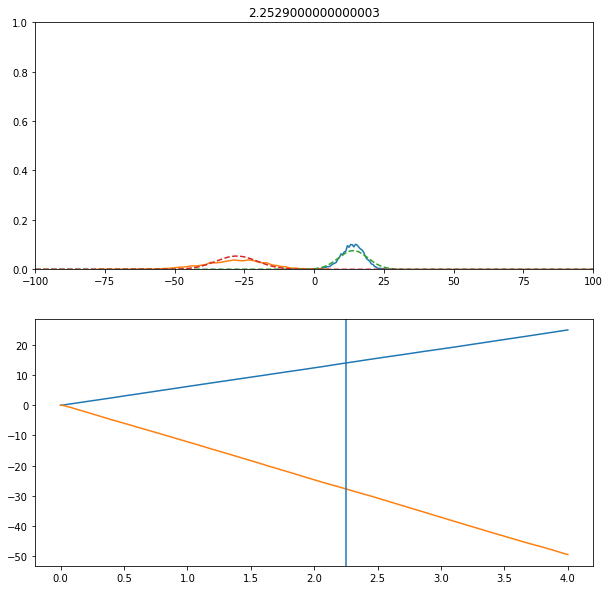

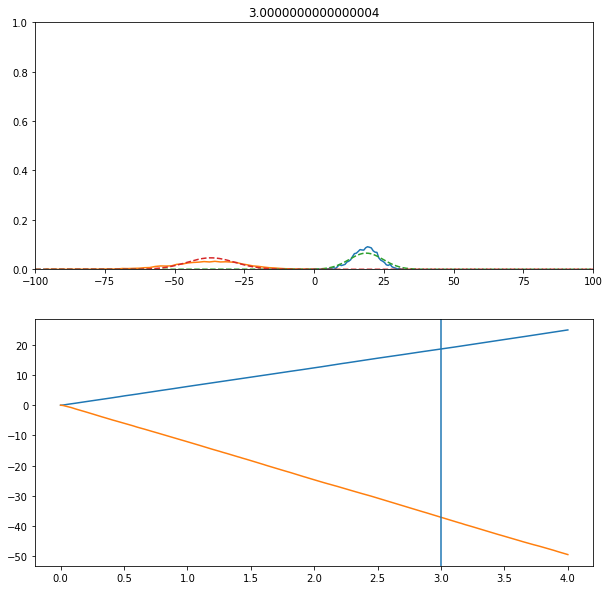

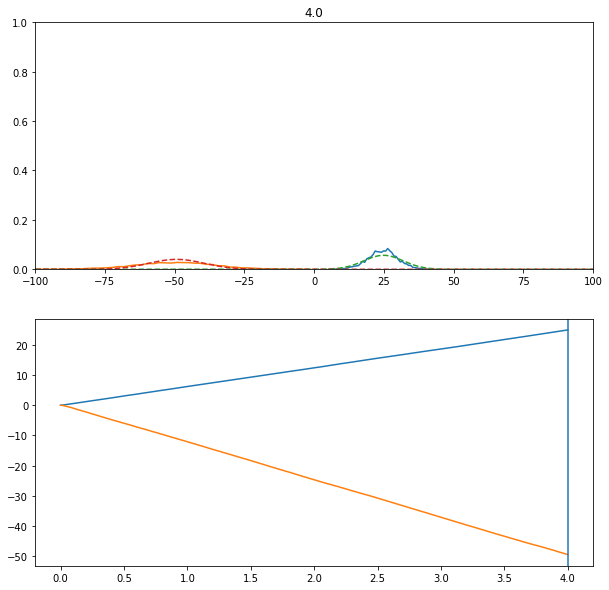

In [34]:
L=100
for ii,k in enumerate(np.linspace(8000,len(timind)-1,10)):

    c1, b1 = np.histogram(ll1[:,int(k)],bins=50, density=True)
    c0, b0 = np.histogram(ll0[:,int(k)],bins=50, density=True)

    plt.figure(figsize=(10,10))
    ax=plt.subplot(211)
    ax.set_title(timind[int(k)])
    ax.plot(b1[:-1], c1)
    ax.plot(b0[:-1], c0)
    t = timind[int(k)]
    eel = np.linspace(-L,L,int(1e4))
    dist1 = [gaussian(l, mu1*t, np.sqrt(2*mu1*t)) for l in eel]
    dist0 = [gaussian(l, mu0*t, np.sqrt(2*abs(mu0*t))) for l in eel]
    ax.plot(eel, dist1,'--')
    ax.plot(eel, dist0,'--')
    ax.set_xlim([-L,L])
    ax.set_ylim([0,1])    
    ax=plt.subplot(212)
    ax.plot(timind, l1)
    ax.plot(timind, l0)
    ax.axvline(timind[int(k)])
    
    plt.savefig("fig_gif/{}.png".format(ii))

# States

In [35]:
path = get_path_config(total_time = 4., dt= 1e-5, itraj=itraj, exp_path=exp_path)


In [36]:
states1 = load_data(exp_path=exp_path, itraj=1, total_time=4. , dt=dt, what="states1.npy")
states2 = load_data(exp_path=exp_path, itraj=1, total_time=4. , dt=dt, what="states1.npy")

In [ ]:
load_states(itraj, mode="damping",dtt=1e-5, to)

In [37]:
n=1
M=int(5*1e3)
ss1 = []
ss0 = []
for itraj in tqdm(range(1,M)):
    states1 = load_data(exp_path=exp_path, itraj=itraj, total_time=4. , dt=dt, what="states1.npy")
    states0 = load_data(exp_path=exp_path, itraj=itraj, total_time=4. , dt=dt, what="states0.npy")
    ss1.append(states1)
    ss0.append(states0)
    
ss1 = np.stack(ss1)
ss0 = np.stack(ss0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:06<00:00, 732.93it/s]


In [43]:
[gamma1, omega1, n1, eta1, kappa1],[gamma0, omega0, n0, eta0, kappa0],   = params

In [75]:
np.sqrt(kappa1*eta1)*dt

0.001

Text(0.5, 1.0, 'h1 true')

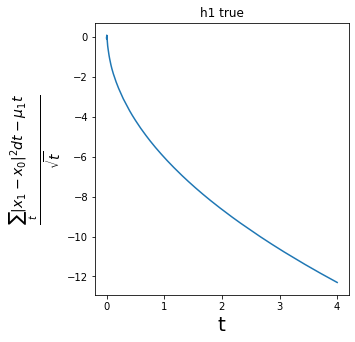

In [136]:
plt.figure(figsize=(10,5))
ax = plt.subplot(121)
ax.plot(timind,(np.cumsum(0.5*4*kappa1*eta1*np.sum((np.abs(ss1[200] - ss0[200]))**2,axis=1))*dt - mu1*np.array(timind))/np.sqrt(timind))
ax.set_ylabel(r'$\frac{\sum_t |x_1 - x_0|^2 dt  -\mu_1 t}{\sqrt{t}}$',size=20)
ax.set_xlabel("t",size=20)
ax.set_title("h1 true")

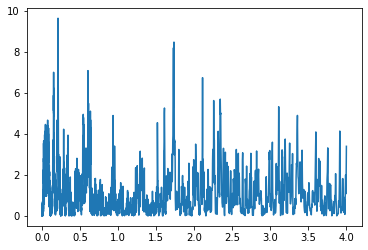

In [137]:
plt.plot(timind,0.5*4*kappa1*eta1*np.sum((np.abs(ss1[20] - ss0[20]))**2,axis=1)/mu1)

In [138]:
diff = ss1 - ss0
C = np.sqrt(4*eta1*kappa1)

In [140]:
dsq = np.einsum('std, std -> st',np.dot(C,diff),np.dot(C,diff))
dst = 0.5*np.mean(dsq,axis=0)

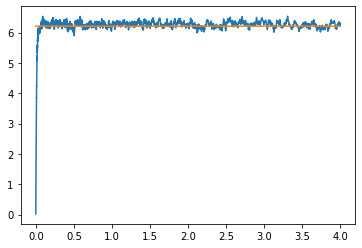

In [142]:
plt.plot(timind,dst)
plt.plot(timind, mu1*np.ones(len(timind)))
